In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from itertools import chain
from joblib import load
import json

In [30]:
class CRFEvaluator:
    def __init__(self, test_data_path, model_path):
        self.test_data = self.load_data_from_json(test_data_path)
        self.model = load(model_path)
        self.labels = ['B-Quantity', 'B-Pizza', 'I-Pizza', 'B-Topping', 'B-Size', 'I-Size', 'O', 'B-Crust', 'I-Crust']

    def word2features(self, sentence, i):
        word = sentence[i]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = sentence[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.isupper()': word1.isupper(),
                '-1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['BOS'] = True

        if i < len(sentence)-1:
            word1 = sentence[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.isupper()': word1.isupper(),
                '+1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['EOS'] = True
            
        return features

    def sentence_features(self, words):
        return [self.word2features(words, i) for i in range(len(words))]

    def sentence_labels(self, labels):
        return labels
    
    def load_data_from_json(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return [(
            item['words'], 
            item['label']
        ) for item in data]
    
    def evaluate_accuracy(self):
        X_test = [self.sentence_features(s[0]) for s in self.test_data]
        y_test = [self.sentence_labels(s[1]) for s in self.test_data]
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(list(chain(*y_test)), list(chain(*y_pred)))
        print(f'Accuracy: {accuracy}')
        return accuracy

    def plot_confusion_matrix(self):
        X_test = [self.sentence_features(s[0]) for s in self.test_data]
        y_test = [self.sentence_labels(s[1]) for s in self.test_data]
        y_pred = self.model.predict(X_test)
        y_test_flat = list(chain(*y_test))
        y_pred_flat = list(chain(*y_pred))
        cm = confusion_matrix(y_test_flat, y_pred_flat, labels=self.labels)

        fig, ax = plt.subplots(figsize=(10, 7))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=self.labels, yticklabels=self.labels,
               title='Confusion Matrix',
               ylabel='True label',
               xlabel='Predicted label')

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2 else "black")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        plt.show()

    def plot_roc_auc(self):
        X_test = [self.sentence_features(s[0]) for s in self.test_data]
        y_test = [self.sentence_labels(s[1]) for s in self.test_data]
        y_pred = self.model.predict(X_test)
        y_test_binarized = label_binarize(list(chain(*y_test)), classes=self.labels)
        y_pred_binarized = label_binarize(list(chain(*y_pred)), classes=self.labels)

        fpr, tpr, roc_auc = {}, {}, {}
        for i, label in enumerate(self.labels):
            fpr[label], tpr[label], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
            roc_auc[label] = auc(fpr[label], tpr[label])

        plt.figure()
        for label in self.labels:
            plt.plot(fpr[label], tpr[label], label=f'{label} (area = {roc_auc[label]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def print_classification_report(self):
        X_test = [self.sentence_features(s[0]) for s in self.test_data]
        y_test = [self.sentence_labels(s[1]) for s in self.test_data]
        y_pred = self.model.predict(X_test)
        y_test_flat = list(chain(*y_test))
        y_pred_flat = list(chain(*y_pred))
        report = classification_report(y_test_flat, y_pred_flat, labels=self.labels, target_names=self.labels)
        print('Classification Report:')
        print(report)

In [49]:
model = CRFEvaluator("../data/labeled/entity/order/test_data.json", '..\output\savedmodels\entity_100_human.h5')

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Admin\AppData\Local\Temp\ipykernel_2324\1137866406.py:1: SyntaxWarning: invalid escape sequence '\o'
  model = CRFEvaluator("../data/labeled/entity/order/test_data.json", '..\output\savedmodels\entity_100_human.h5')


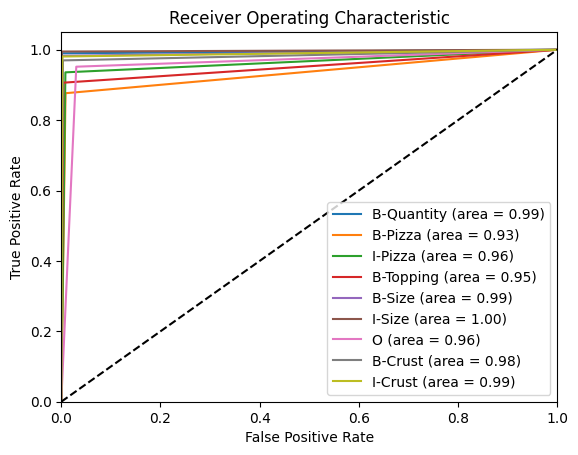

In [50]:
model.plot_roc_auc()